In [1]:
# GPU
import os
from tensorflow import test, config
if test.is_gpu_available():
    print("O GPU available O")
    print("GPU :", config.list_physical_devices('GPU'))
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    print("X GPU NOT available X")
    

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
O GPU available O
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import os
import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
import pprint as pp
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

# Load Metadata

In [3]:
base_skin_dir = os.path.join('.')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))


data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


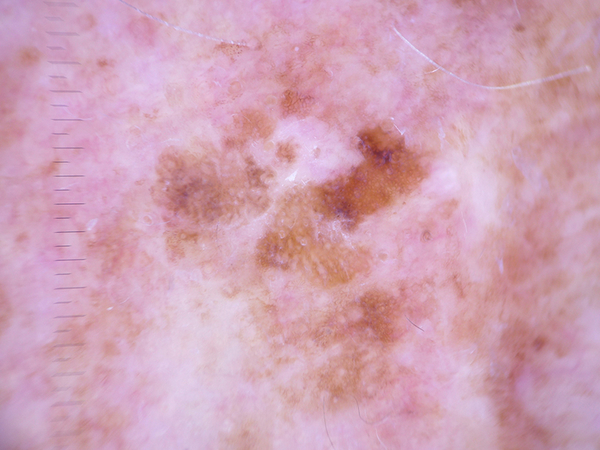

In [4]:
Image.open(data['path'][0])

<Axes: xlabel='cell_type'>

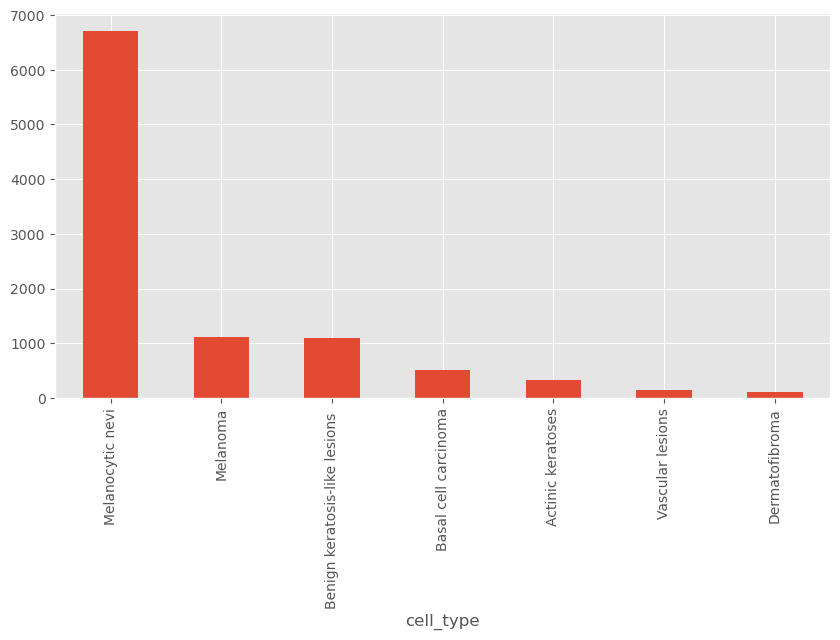

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

# Load images

In [6]:
def crop_balanced_dataset(df):
    df_cropped = pd.DataFrame()

    for i in range(len(df)):
        row = df.iloc[i:i+1, :].copy()
        t = (row['cell_type_idx']!=4).bool()

        if (t==True):
            original_image = cv2.imread(df['path'][i])

            upper_left = original_image[:300, :400, 0:3]
            upper_right = original_image[:300, 200:, 0:3]
            down_left = original_image[150:, :400, 0:3]
            down_right = original_image[150:, 200:, 0:3]

            for cropped in [upper_left, upper_right, down_left, down_right] :
                row['path'] = [cropped]
                df_cropped = pd.concat([df_cropped, row])
    
    df_cropped = pd.concat([df,df_cropped])

    return df_cropped


def load_img_data(size, df, balanced=False):

    img_h, img_w = size, size
    imgs = []

    if balanced:
        df = crop_balanced_dataset(df)

    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        if (type(image_paths[i])==str):
            img = cv2.imread(image_paths[i])
        else:
            img = image_paths[i]

        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    return imgs, df['cell_type_idx'].values

In [7]:
class InceptionBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(InceptionBlock, self).__init__()

        self.conv1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')

        self.conv3x3_reduce = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')
        self.conv3x3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')

        self.conv5x5_reduce = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')
        self.conv5x5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')

        self.pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')
        self.conv1x1pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')

    def call(self, x):
        conv1x1 = self.conv1x1(x)

        conv3x3_reduce = self.conv3x3_reduce(x)
        conv3x3 = self.conv3x3(conv3x3_reduce)

        conv5x5_reduce = self.conv5x5_reduce(x)
        conv5x5 = self.conv5x5(conv5x5_reduce)

        pool = self.pool(x)
        conv1x1pool = self.conv1x1pool(pool)

        inception_block = layers.concatenate([conv1x1, conv3x3, conv5x5, conv1x1pool], axis=-1)

        return inception_block
    

class GoogleNet(object):
    def __init__(self, data, classes, epochs, batch_size, k_folds=5):
        self.input_shape = data[0][0].shape
        
        self.trainX = data[0]
        self.trainY = data[1]
        self.testX = data[2]
        self.testY = data[3]
        
        self.CLASSES = classes
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size
        self.K_FOLDS = k_folds

        self.train_generator = self.data_augmentation()

    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                shear_range=0.1,
                width_shift_range=0.1, 
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        return train_generator
    

    def k_fold_cross_validation(self):
        skf = StratifiedKFold(n_splits=self.K_FOLDS, shuffle=True, random_state=42)
        tf.random.set_seed(42)
        acc_scores = []

        X = np.concatenate([self.trainX, self.testX], axis=0)
        y = np.concatenate([self.trainY, self.testY], axis=0)

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            if (fold==0):
                self.model = self.build()
                self.model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
                # self.model.save_weights('GoogleNet_model_init_weights.h5')
                print(self.model.summary())
            
            self.model.load_weights('GoogleNet_model_init_weights.h5')
            
            print(f"Training Fold {fold + 1}/{self.K_FOLDS}")
            history = self.model.fit(
                # X_train, y_train,
                self.train_generator,
                steps_per_epoch=X_train.shape[0] // self.BATCH_SIZE,
                epochs=self.EPOCHS)
            
            print('\nPredicting test set classes.')
            score = self.model.evaluate(X_test, y_test, batch_size=self.BATCH_SIZE)
            print('Test set loss:', score[0], 'Test set ACC:', score[1])

            y_pred_prob = self.model.predict(X_test)
            y_pred_class = np.argmax(y_pred_prob, axis=1)
            print(classification_report(y_test, y_pred_class, digits=4, zero_division=1))

            acc_scores.append(score[1])
            print('Done')
            print() # New line for the next fold
        
        print('All learning has done')
        print('Average ACC:', round(sum(acc_scores) / self.K_FOLDS, 4))


    def build(self):
        # Define the network
        # 입력 레이어
        input_layer = layers.Input(shape=self.input_shape)

        # Convolutional layers
        x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
        x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        # Inception blocks
        x = InceptionBlock([64, 96, 128, 16, 32, 32])(x)
        x = InceptionBlock([128, 128, 192, 32, 96, 64])(x)
        x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
        x = InceptionBlock([192, 96, 208, 16, 48, 64])(x)

        # Average pooling
        x = layers.GlobalAveragePooling2D()(x)

        # Fully connected layers
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        output = layers.Dense(7, activation='softmax')(x)

        # 모델 생성
        model = Model(inputs=input_layer, outputs=output)

        return model
    


In [8]:
# 이미지 불러오기
imgs, target = load_img_data(64, data.iloc[:], balanced=False)

100%|██████████| 10015/10015 [00:46<00:00, 213.41it/s]


(10015, 64, 64, 3)


In [9]:
# 학습 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20, shuffle=True, random_state=42)

train_test = (X_train, y_train, X_test, y_test)

[X_train.shape, X_test.shape]

[(8012, 64, 64, 3), (2003, 64, 64, 3)]

In [10]:
# GPU 메모리 정리
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
with tf.Graph().as_default():
  gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

In [11]:
tf.random.set_seed(42)

CLASSES = len(set(target))
BATCH_SIZE = 128
EPOCHS = 300

model = GoogleNet(train_test, CLASSES, EPOCHS, BATCH_SIZE)
model.k_fold_cross_validation()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 inception_block (InceptionB  (None, 16, 16, 256)      137072    
 lock)                                                           
                                                                 
 inception_block_1 (Inceptio  (None, 16, 16, 480)      388736    
 nBlock)                                                         
                                                             

In [12]:
model.model.save_weights('GoogleNet_model_64A_300_weights.h5')

In [15]:
model.model.save('GoogleNet_model_64A_300')

INFO:tensorflow:Assets written to: GoogleNet_model_64A_300\assets


INFO:tensorflow:Assets written to: GoogleNet_model_64A_300\assets
